# PC Lab 5: Resampling Methods for Model Evaluation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import pc5

---

## Introduction

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/2880px-K-fold_cross_validation_EN.svg.png" width=500>

This tutorial is about an important tool for evaluating how accurate your model will perform in practice: _Resampling methods_ are an dispensable tool in modern statistics and involve repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain additional information about
the fitted model. 

For example, in order to estimate the variability of a linear regression fit, we can repeatedly draw different samples from the training data, fit a linear regression to each new sample, and then examine the
extent to which the resulting fits differ. Such an approach may allow us to obtain information that would not be available from fitting the model only once using the original training sample. 

Resampling approaches can be computationally expensive, because they involve fitting the same statistical method multiple times using different subsets of the training data. However, due to recent advances in computing
power, the computational requirements of resampling methods generally are not prohibitive. In this PC lab, we discuss two of the most commonly used resampling methods, _cross-validation_ and nested cross-validation.


We again first load the necessary files for this PC-lab:

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/BioML-UGent/MLLS/main/05_evaluation/pc5.py",
                           "pc5.py") # helper functions used for feature and label creation
urllib.request.urlretrieve("https://raw.githubusercontent.com/BioML-UGent/MLLS/main/05_evaluation/promoters.csv",
                           "promoters.csv")

('promoters.csv', <http.client.HTTPMessage at 0x16a627c10>)

## Data exploration: A simple promoter library

The dataset used for the first exercise is a simpe [E. coli promoter database](https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.names) that contains a set of both promoter regions and non-promoter regions. A promoter region is the DNA sequence upstream of genes to which the RNA polymerase binds before the transcription of genes is initiated.

<img src="https://ib.bioninja.com.au/_Media/sections-of-a-gene_med.jpeg" width=500>

<div class="alert alert-success">
    <h1>Exercise 5.1</h2>
        <p><b>Load in</b> the data and <b>explore</b>. Use <code>pd.Series.value_counts()</code> to evaluate the labels. The data is stored in <code>promoters.csv</code></p>
</div>

In [5]:
df_data = pd.read_csv("promoters.csv")
df_data.head()

,True,S10,agtatgtataatgcgcgggcttgtcgt
0,True,AMPC,tgtcgttacaatctaacgcatcgccaa
1,True,AROH,ttttgttatcatgctaaccacccggcg
2,True,DEOP2,agtagatgttagaatactaacaaactc
3,True,LEU1_TRNA,aaccactagaatgcgcctccgtggtag
4,True,MALEFG,tataaagaaactagagtccgtttaggt


**We see the first column is not used to identify column names**. Hence, we can just load the dataframe without its headings, setting <code>header=None<code>.

In [6]:
df_data = pd.read_csv("promoters.csv", header=None)
df_data.head()

,0,1,2
0,True,S10,agtatgtataatgcgcgggcttgtcgt
1,True,AMPC,tgtcgttacaatctaacgcatcgccaa
2,True,AROH,ttttgttatcatgctaaccacccggcg
3,True,DEOP2,agtagatgttagaatactaacaaactc
4,True,LEU1_TRNA,aaccactagaatgcgcctccgtggtag


Now evaluate the distribution of the 2 labels, using the built-in pandas function <code>pd.Series.value_counts()</code>. Is our dataset balanced?

In [7]:
df_data[0].value_counts(dropna=False)

0
True     53
False    53
Name: count, dtype: int64

In [8]:
len(df_data)

106

**We aee that we are working with a balanced dataset, there are no invalid entries in the column for labels.**

<div class="alert alert-success">
    <h2>Exercise 5.1.1</h2>
                <p><b>Create</b> the features and labels for the model. Create your own features, use results from the previous PC lab or use <code>pc5.CreateDummyNucleotideFeatures()</code>. To explore how this function works, tap `Shift+Tab` within the brackets of the written out function (autocompleted with tapping `Tab`). For the labels, take a look at the <code>sklearn.preprocessing.LabelEncoder</code> class.</p>
</div>

In [10]:
X = pc5.CreateDummyNucleotideFeatures(df_data[2], 27)
#get numpy array from pandas dataframe
X = X.values

y = LabelEncoder().fit_transform(df_data[0])

**As given in the docstring: for the features, a pandas DataFrame object is returned. To transform into numpy array, use the <code>pd.DataFrame.values</code> function.**

---

In this section we will elaborate on two specific questions that are strongly related to cross-validation. Both questions stem from the fact that we aim to build models with a high predictive power, based on a finite dataset.
 - **Question 1**: Given a relatively small dataset, how can we use the promoter dataset as efficiently as possible, to construct a model that  optimally predicts the existence of a promoter region in the prokaryotic DNA?
 - **Question 2**: How can we decide which machine learning method should be preferred to predict the presence of a promoter region?


### Question 1: cross-validation

To construct the optimal model, we need to **select the hyperparameter that works best for the model**. Since our data set is small, we want to prevent overfitting of the model on the training data. As a result, two datasets are needed, one to train the initial model (training dataset) and one
to validate the model and choose the model with the optimal hyperparameters (validation- or tuning dataset). The original dataset is split in 2 parts randomly. Often 75% of the data is used for training and 25% for tuning.

The accuracy and error are computed for each split on the data used for tuning, and then the average is taken as an overall measure of evaluation:

$$
Error = \frac{1}{k} \sum_{i=1}^{k} \frac{1}{|s_i|} \sum_{j\in s_i}L(x_j, f(x_j)) \tag{1}\\
$$
$$
Accuracy = \frac{1}{k} \sum_{i=1}^{k} ACC_i
$$

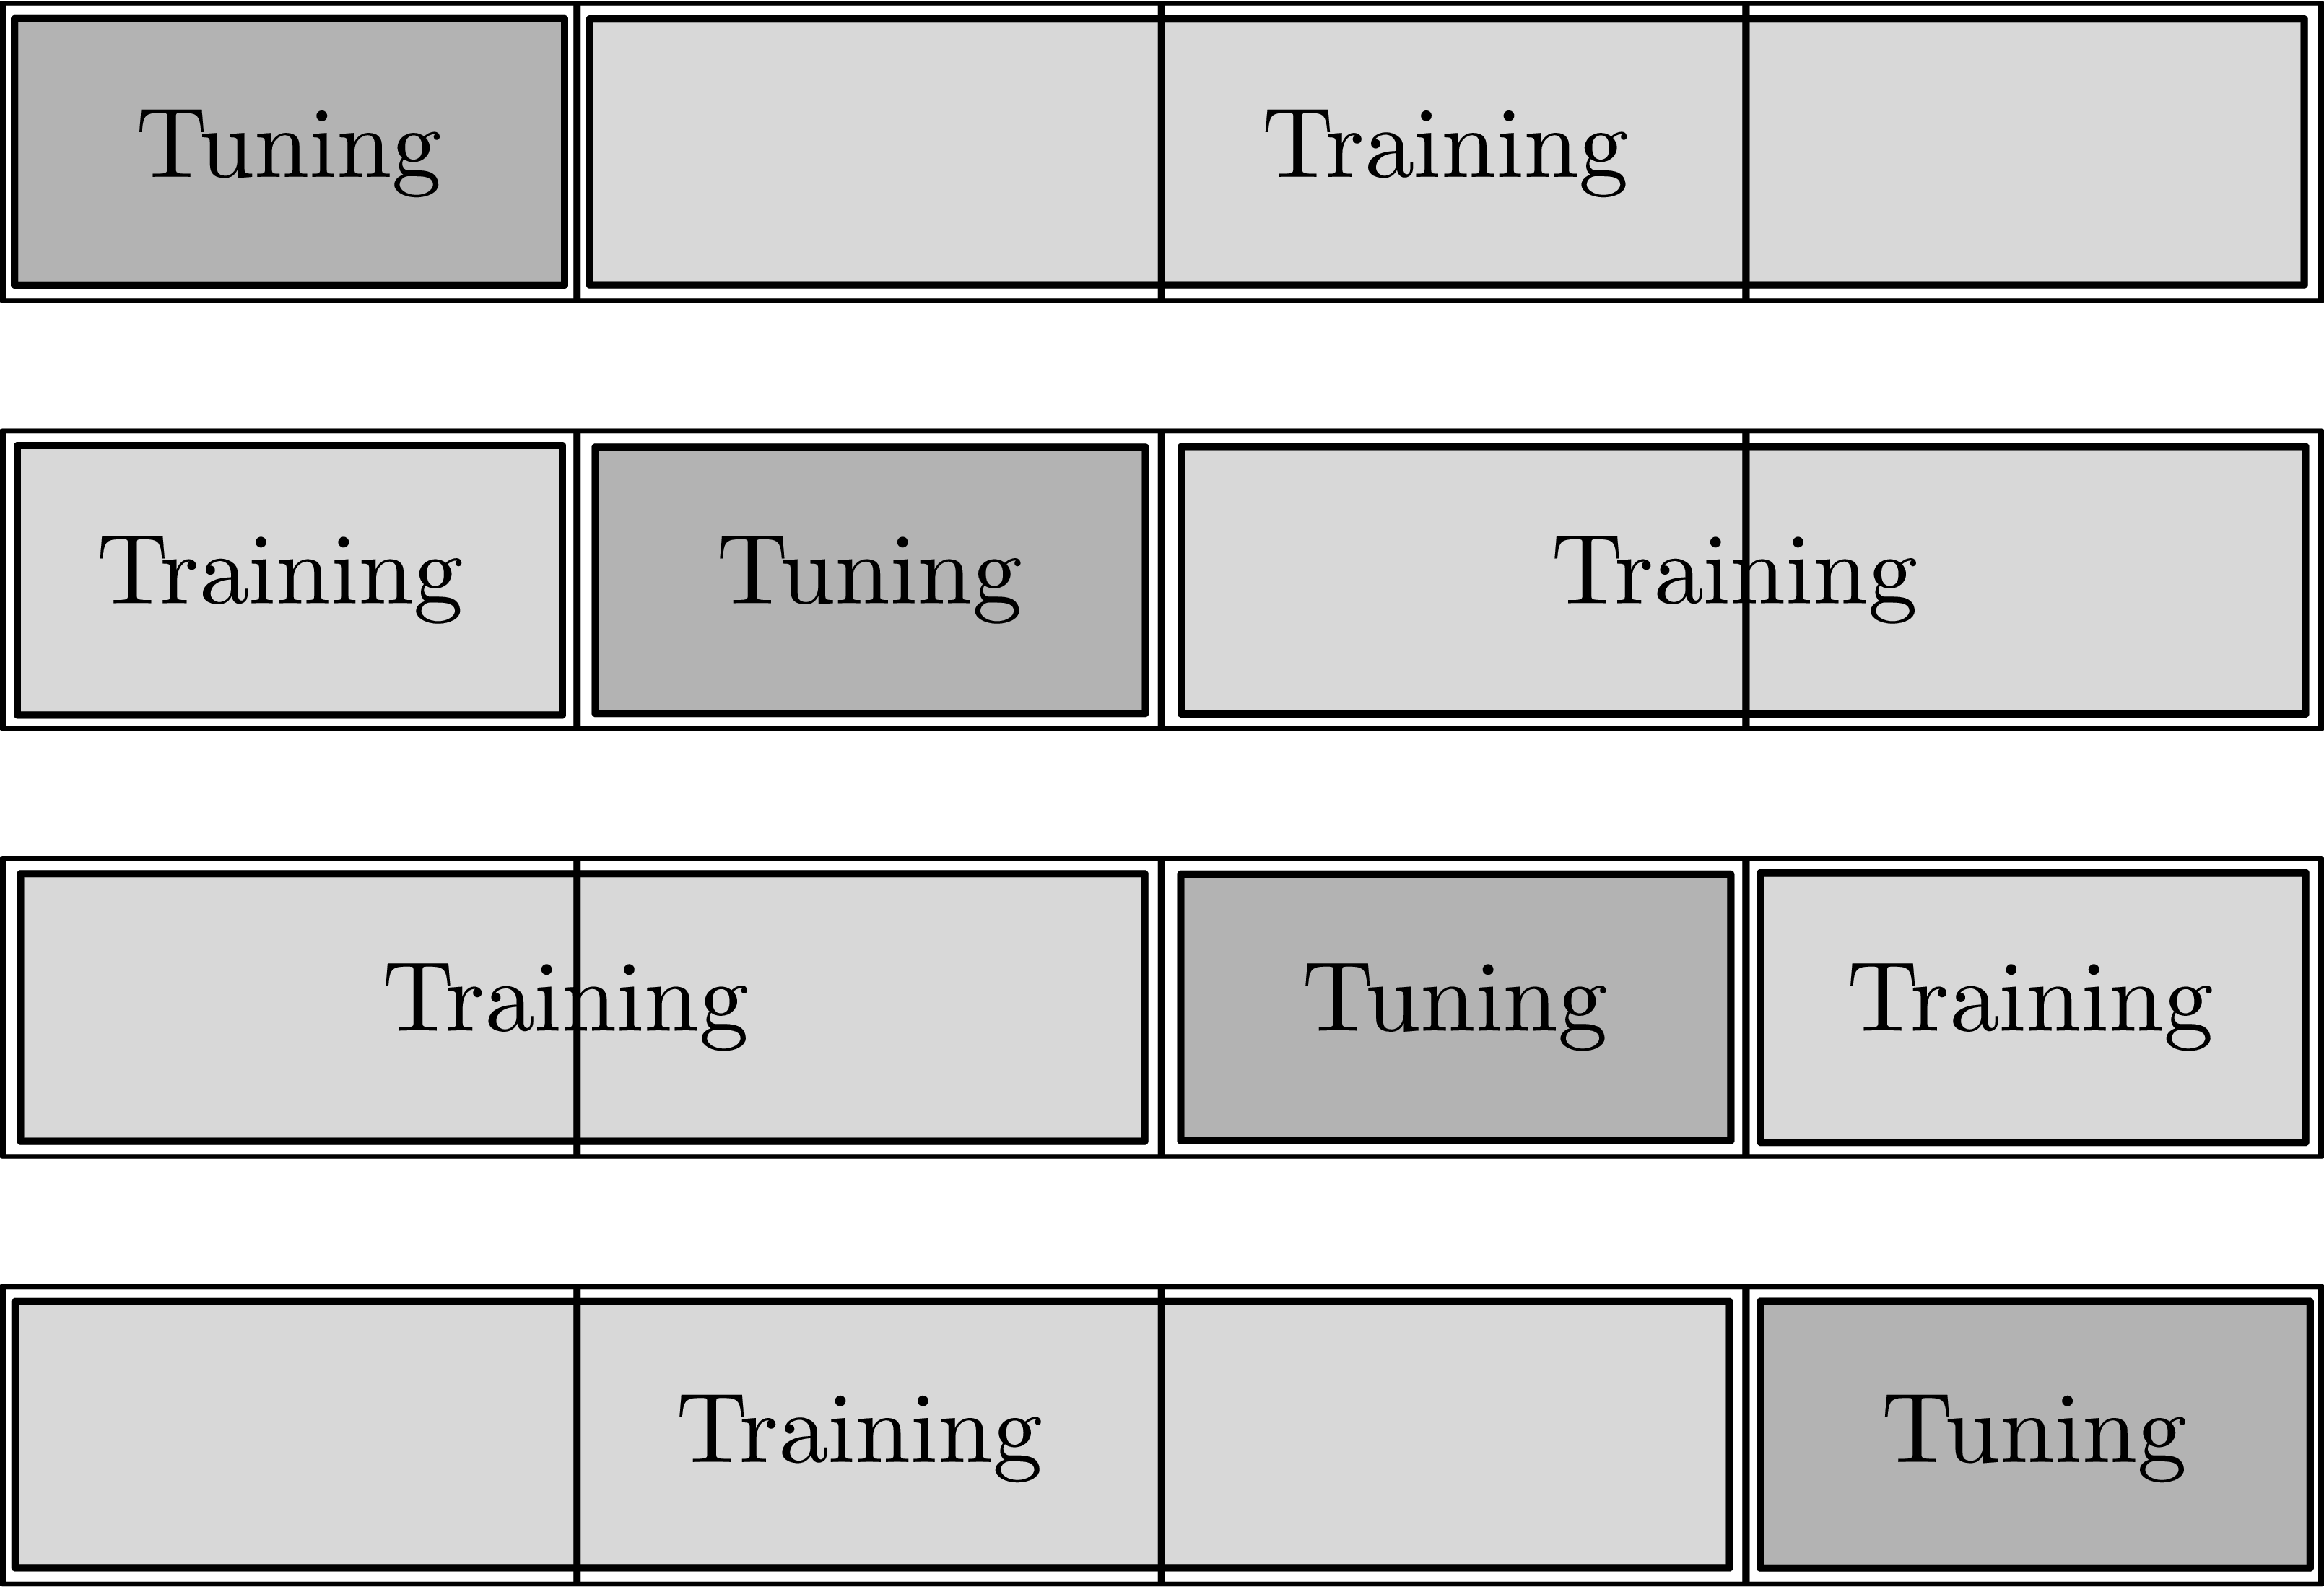

<div class="alert alert-success">
    <h2>Exercise 5.1.2</h2>
        <p><b>Write out</b> code that performs the cross-validation using the <code>StratifiedKFold()</code> function. Use <b>four folds</b> using the nearest neighbors methodology. <b>Determine</b> the optimal amount of neighbors to maximize the model accuracy. In particular

  - choose a predefined list of number of neighbors (e.g. the range 1 to 20)
  - for each split and each number of neighbors, calculate the score of the $k$ nearest neighbor classifier
  - plot the average score for each number of neighbors.
  
  What is the optimal number of neighbors? </p>

</div>

Maximum Accuracy with 8 neighbors


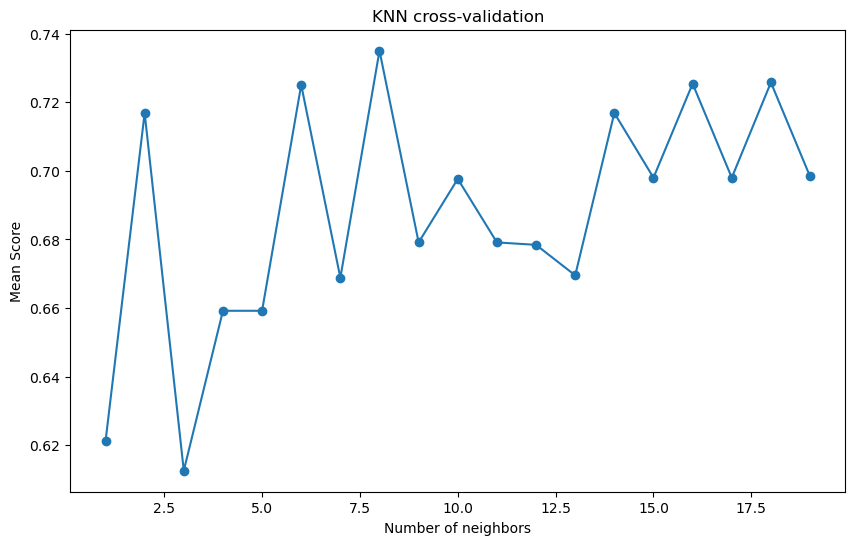

In [15]:
fold_scores = []
# define space to iterate over
space = np.arange(1,20)
# define folds
folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for tr_idx, tu_idx in folds.split(X,y):
    hyper_scores = [] # store scores for each hyperparameter (number of neighbors in thiss case)
    for hyper in space:
        knn = KNeighborsClassifier(n_neighbors=hyper)
        knn.fit(X[tr_idx],y[tr_idx]) #fit calssifier on training data
        score = knn.score(X[tu_idx], y[tu_idx]) # evaluate score on leave-out data
        hyper_scores.append(score)
    fold_scores.append(hyper_scores)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(space, np.mean(fold_scores, axis=0), "-o") # use the mean of the scores for each hyperparameter
ax.set_xlabel("Number of neighbors")
ax.set_ylabel("Mean Score")
ax.set_title("KNN cross-validation")

print(f"Maximum Accuracy with {space[np.argmax(np.mean(fold_scores, axis=0))]} neighbors")

<div class="alert alert-success">
    <h2>Exercise 5.1.3</h2>
        <p><b>Copy</b> your code from the previous exercize below. Replace the plot function with <code>ax.errorbar()</code> and add the variance of the mean scores displayed as vertical bars. In what range do they lie? </p>
</div>

Text(0.5, 1.0, 'KNN cross-validation with error bars')

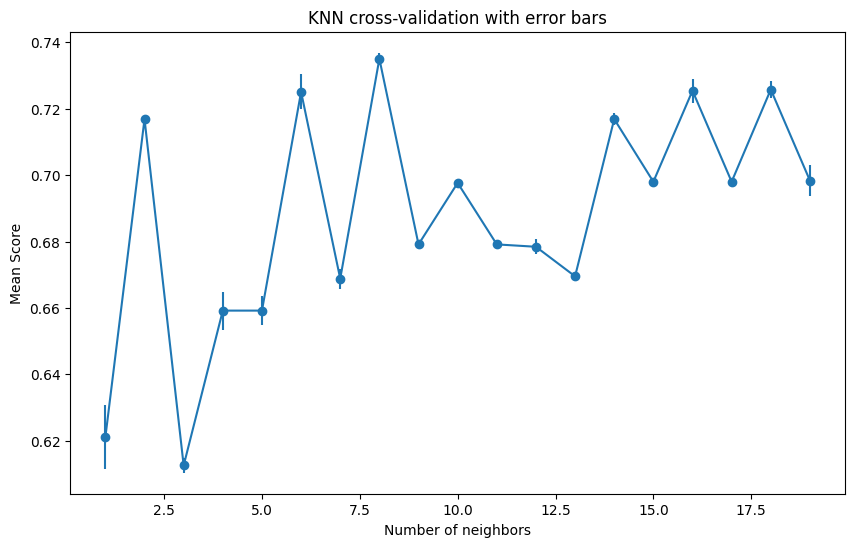

In [18]:
fold_scores = []
# define space to iterate over
space = np.arange(1,20)
# define folds
folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)


for tr_idx, tu_idx in folds.split(X,y):
    hyper_scores = []
    for hyper in space:
        knn = KNeighborsClassifier(n_neighbors=hyper)
        knn.fit(X[tr_idx],y[tr_idx])
        score = knn.score(X[tu_idx], y[tu_idx])
        hyper_scores.append(score)
    fold_scores.append(hyper_scores)
fig, ax = plt.subplots(1,1,figsize=(10,6))

# ax.plot(space, np.mean(fold_scores, axis=0))
ax.errorbar(space,np.mean(fold_scores,axis=0),np.var(fold_scores,axis=0),fmt='-o')
ax.set_xlabel("Number of neighbors")
ax.set_ylabel("Mean Score")
plt.title("KNN cross-validation with error bars")


In [16]:
np.var(fold_scores, axis=0)

array([9.56972752e-03, 3.84914692e-04, 2.17936543e-03, 5.70142998e-03,
       4.32968787e-03, 5.24447854e-03, 3.02503632e-03, 1.82628388e-03,
       3.93031509e-04, 9.60194114e-04, 3.93031509e-04, 2.27511851e-03,
       4.17001485e-04, 1.75665680e-03, 7.18338325e-04, 3.61134954e-03,
       3.24672689e-05, 2.66383796e-03, 4.64522914e-03])

<div class="alert alert-success">
    <h2>Exercise</h2>
        <p><b>Evaluate</b> the variance of these values for an increasing amount of folds. Use as many folds as possible. Applying cross-validation with n-1 folds is considered as <u>Leave-One-Out (LOO) cross-validation</u>.. Note that using the <code> StratifiedKFold</code> method restricts you to $\frac{n}{2}$ number of folds, as it wants to preserve the percentage of samples per each class.</p>
        <p><b>Consider</b> the advantages and disadvantages of using few/many folds?</p>
</div>


Optimal number of neighbors: 2


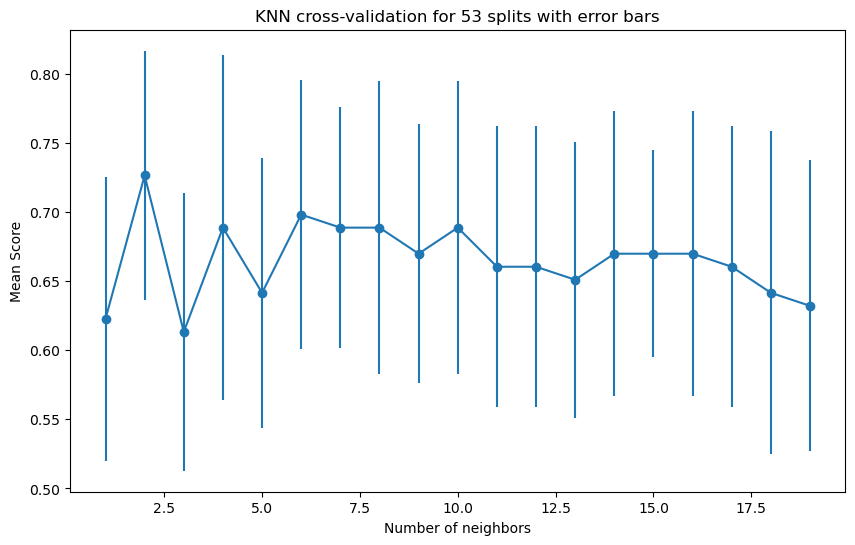

In [20]:
n_splits = 53

fold_scores = []
# define space to iterate over
space = np.arange(1,20)
# define folds
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


for tr_idx, tu_idx in folds.split(X,y):
    hyper_scores = []
    for hyper in space:
        knn = KNeighborsClassifier(n_neighbors=hyper)
        knn.fit(X[tr_idx],y[tr_idx])
        score = knn.score(X[tu_idx], y[tu_idx])
        hyper_scores.append(score)
    fold_scores.append(hyper_scores)
fig, ax = plt.subplots(1,1,figsize=(10,6))

# ax.plot(space, np.mean(fold_scores, axis=0))
plt.errorbar(space,np.mean(fold_scores,axis=0),np.var(fold_scores,axis=0), fmt='-o')
ax.set_xlabel("Number of neighbors")
ax.set_ylabel("Mean Score")
plt.title(f"KNN cross-validation for {n_splits} splits with error bars")

print(f"Optimal number of neighbors: {space[np.argmax(np.mean(fold_scores, axis=0))]}")

Optimal number of neighbors: 2


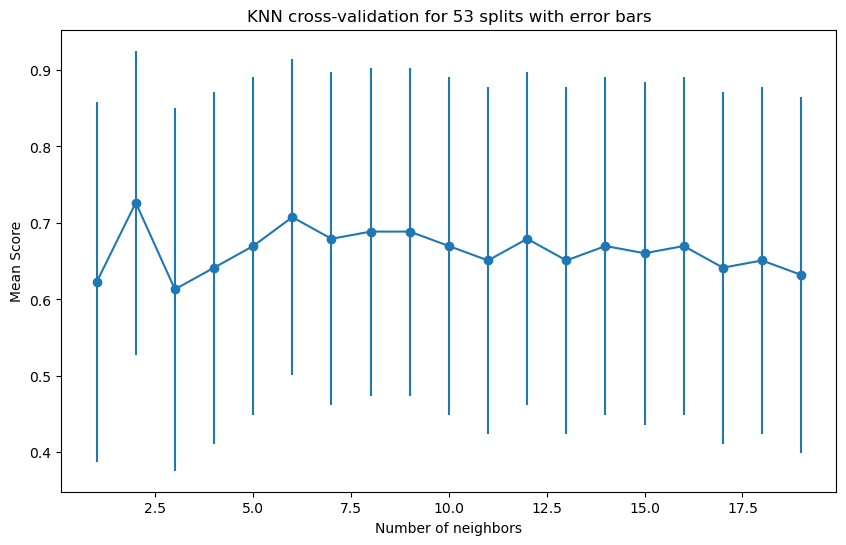

In [19]:
fold_scores = []
# define space to iterate over
space = np.arange(1,20)
# define folds
folds = LeaveOneOut()


for tr_idx, tu_idx in folds.split(X,y):
    hyper_scores = []
    for hyper in space:
        knn = KNeighborsClassifier(n_neighbors=hyper)
        knn.fit(X[tr_idx],y[tr_idx])
        score = knn.score(X[tu_idx], y[tu_idx])
        hyper_scores.append(score)
    fold_scores.append(hyper_scores)
fig, ax = plt.subplots(1,1,figsize=(10,6))

# ax.plot(space, np.mean(fold_scores, axis=0))
plt.errorbar(space,np.mean(fold_scores,axis=0),np.var(fold_scores,axis=0), fmt='-o')
ax.set_xlabel("Number of neighbors")
ax.set_ylabel("Mean Score")
plt.title(f"KNN cross-validation for {n_splits} splits with error bars")

print(f"Optimal number of neighbors: {space[np.argmax(np.mean(fold_scores, axis=0))]}")

**By increasing the amount of folds, a larger training dataset for each split is obtained. When using small datasets (like we are doing now) this is often necessary as otherwise too much information is lost in the large tuning dataset. This can also be observed by a more stable result when running cross-validation over multiple random states. We can see that by increasing the folds the result becomes more stable (same-ish over different random seeds). The optimal amount of neighbors is 2.**

- LOO is way slower.
- LOO gives stable solutions, unlike 4-fold which can give different solutions over different runs.
- The tuning estimate of the test error rate becomes highly variable, depending on precisely which observations are included in the training set and which observations are included in the tuning set. (bias-variance tradeoff)
- In the tuning approach, only a subset of the observations—those that are included in the training set rather than in the tuning set—are used to fit the model. Since statistical methods tend to perform worse when trained on fewer observations, it suggests that the tune set error rate tends to underestimate the performance of the model fit on the entire data set.

**We strife to select a fold size that has both a stable result (i.e. selected optimal hyperparameter) over different data splits (i.e. random seed, improved by increasing training samples -> more folds) and over the different folds (often improved by decreasing variability of tune set, i.e. more tune samples) -> less folds)**



## (*Optional*) Question 2: Nested Cross-Validation

The best model is the one which is able to predict the labels of
new instances most accurately (where accuracy is expressed by a performance measure). To be able **to make an unbiased estimate of your model performance, e.g. for comparison of two different methods**, it is important to exclude any bias. To obtain this estimate, the accuracy of the model must be determined on
a dataset that is neither used for building nor for tuning the models. This dataset is called the test set and is set aside in the very beginning of the model building process. 

_Nested cross-validation_ is used to train a model in which hyperparameters also need to be optimized. Nested CV estimates the generalization error of the underlying model and its (hyper)parameter search. Choosing the parameters that maximize non-nested CV biases the model to the dataset, yielding an overly-optimistic score.

Model selection without nested CV uses the same data to tune model parameters and evaluate model performance. Information may thus “leak” into the model and overfit the data. The magnitude of this effect is primarily dependent on the size of the dataset and the stability of the model.

To put this more formally, the following steps are taken:
1. Select a part (for instance 25 %) of the data as test data and put it aside.
2. Use the other part of the data (training/tuning data) to select an optimal set of hyperparameters.
3. Build a new model on the training/tuning data using the optimal hyperparameters
4. Compute the prediction accuracy (or another performance measure) of the final models on the test dataset. Apply for all outer folds and choose the model with the highest averaged accuracy.


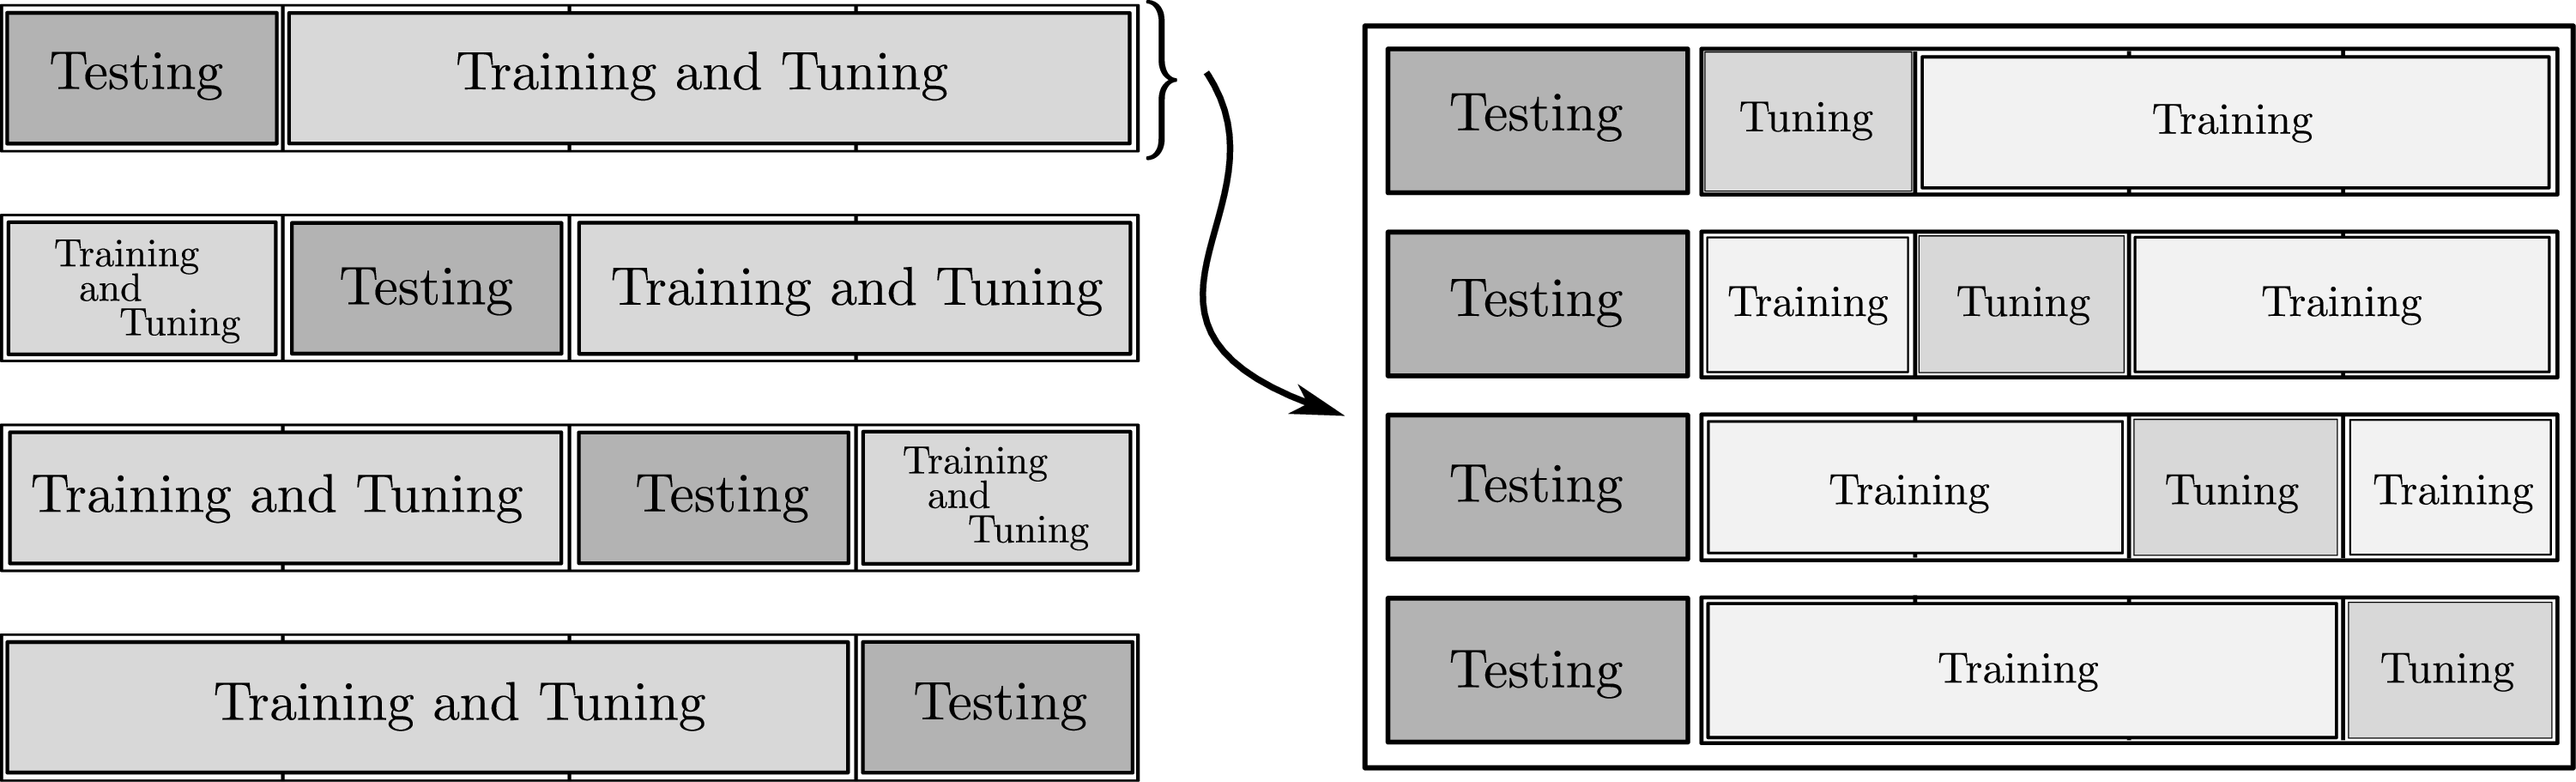

<div class="alert alert-success">
    <h2>Exercise 5.2.1</h2>
        <p><b>Write out</b> code that performs the nested cross-validation. compare the results on two models using k nearest neighbours and logistic discriminant analysis (solver: 'eigen', hyperparameter: 'shrinkage'). In particular

- define the number of "outer" nd "innner" splits, where the outer splits are done for dividing into train/tune and test set, and the inner splits for splitting the train/tune into train and tune
- define a hyperparameter space over which to iterate and evaluate the model performance
- fit the model on the train data used for the current split and calculate the score on the remaining data used for tuning
- using the mean score on the tuning data, save the optimal hyperparameter for each "outer" fold, that will be used for the evaluatin on the test set
- fit your model using the optimal parameter on the respective outer fold train data, evaluate on the test data
- plot the scores for the test data for each (outer) fold
- plot the scores on the tuning data for each (outer) fold, using the optimal hyperparameter and the mean over the inner folds
         </p>
</div>

### 1. Evaluating $k$-nearest neighbors using Nested Cross-Validation

mean test score: 0.6875
mean tune score: 0.729375


Text(0.5, 1.0, 'KNN NEsted Cross Validation for 12 outer splits')

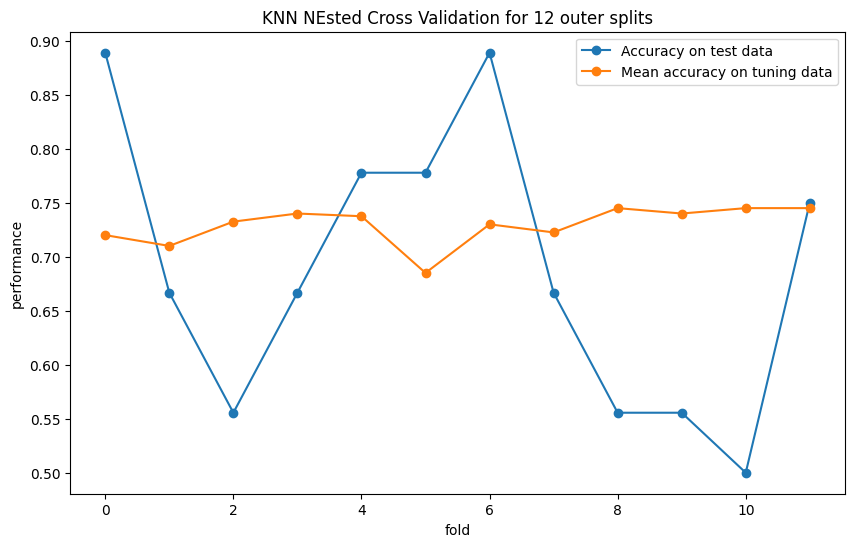

In [36]:
# list containing scores on test set
test_scores = []
# list containing max (mean score) on tuning set
max_scores = []
# list optimal hyperparameter for each fold
opt_pars_in = []
opt_pars_out = []
# define space to iterate over
space = np.arange(1,20)
# define folds
outer_splits = 12 # splits to divide in training and testing
inner_splits = 20 # splits to divide in training and tuning
outer_folds = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=1)
inner_folds = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=1)

#split in training/tuning and testing data
for trtu_idx, te_idx in outer_folds.split(X,y):
    X_trtu, y_trtu = X[trtu_idx], y[trtu_idx] # select training/tuning data
    fold_scores = []
    for tr_idx, tu_idx in inner_folds.split(X_trtu,y_trtu):
        hyper_scores = []
        for i, hyper in enumerate(space):
            knn = KNeighborsClassifier(n_neighbors=hyper, metric='jaccard')
            knn.fit(X_trtu[tr_idx],y_trtu[tr_idx]) # fit on trianing data
            score = knn.score(X_trtu[tu_idx], y_trtu[tu_idx]) # calculate score on test data
            hyper_scores.append(score)
        opt_pars_in.append(space[np.argmax(hyper_scores)]) # save optimal number of neighbors
        fold_scores.append(hyper_scores)
    opt_pars_out.append(space[np.argmax(np.mean(fold_scores, axis=0))]) # save optimal number of neighbors, using mean score on tuning data
    # score of model using optimal hyperpar. on tuning data
    max_scores.append(np.max(np.mean(fold_scores, axis=0)))
    
    # fit and evaluate on test set using optimal parameter
    knn = KNeighborsClassifier(n_neighbors=opt_pars_out[-1])
    knn.fit(X_trtu,y_trtu)
    test_scores.append(knn.score(X[te_idx],y[te_idx]))


fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(np.arange(outer_splits), test_scores, '-o', label="Accuracy on test data")
ax.plot(np.arange(outer_splits), max_scores, '-o', label="Mean accuracy on tuning data")
ax.set_xlabel('fold')
ax.set_ylabel('performance')
ax.legend()

print("mean test score: {}".format(np.mean(test_scores)))
print("mean tune score: {}".format(np.mean(max_scores)))
#plt.errorbar(space,np.mean(fold_scores,axis=0),np.var(fold_scores,axis=0))
plt.title(f"KNN NEsted Cross Validation for {outer_splits} outer splits")

## 2. Evaluating LDA using Nested Cross-Validation

mean test score: 0.5578703703703705
mean tune score: 0.7752083333333334


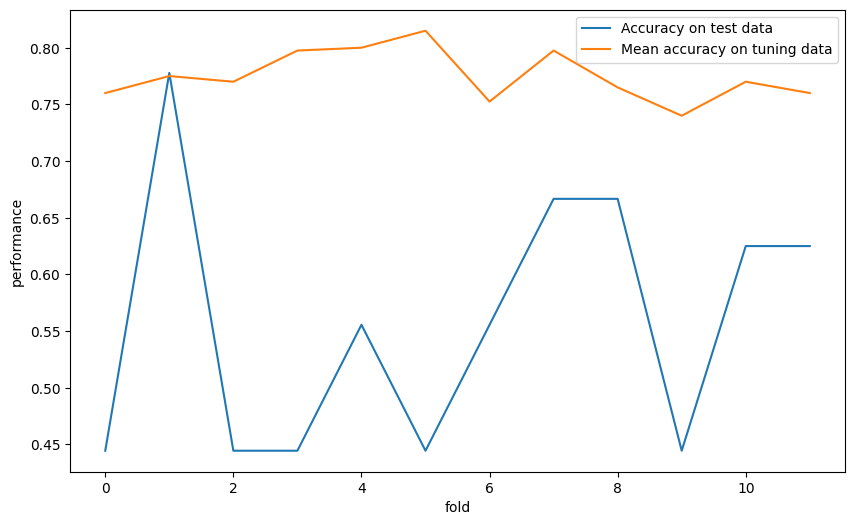

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')
# list containing scores on test set
test_scores = []
# list containing max (mean score) on tuning set
max_scores = []
# define space to iterate over
space = np.arange(0,1.1,0.2)
# list optimal hyperparameter for each fold
opt_pars_in = []
opt_pars_out = []
# define folds
outer_splits = 12
inner_splits = 20
outer_folds = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=2)
inner_folds = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=2)

#split in training/tuning and testing data
%timeit
for trtu_idx, te_idx in outer_folds.split(X,y):
    X_trtu, y_trtu = X[trtu_idx], y[trtu_idx]
    fold_scores = []
    for tr_idx, tu_idx in inner_folds.split(X_trtu,y_trtu):
        hyper_scores = []
        for i, hyper in enumerate(space):
            lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=hyper)
            lda.fit(X_trtu[tr_idx], y_trtu[tr_idx])
            score = lda.score(X_trtu[tu_idx], y_trtu[tu_idx])
            hyper_scores.append(score)
        opt_pars_in.append(space[np.argmax(hyper_scores)])
        fold_scores.append(hyper_scores)
    opt_pars_out.append(space[np.argmax(np.mean(fold_scores, axis=0))])
    # keep max score on fold
    max_scores.append(np.max(np.mean(fold_scores, axis=0)))
    # fit and evaluate on test set using optimal parameter
    lda = LinearDiscriminantAnalysis(tol=opt_pars_out[-1])
    lda.fit(X_trtu,y_trtu)
    test_scores.append(lda.score(X[te_idx],y[te_idx]))


fig, ax1 = plt.subplots(1,1,figsize=(10,6))
ax1.plot(np.arange(outer_splits), test_scores, label="Accuracy on test data")
ax1.plot(np.arange(outer_splits), max_scores, label="Mean accuracy on tuning data")
ax1.legend()
ax1.set_xlabel('fold')
ax1.set_ylabel('performance')

print("mean test score: {}".format(np.mean(test_scores)))
print("mean tune score: {}".format(np.mean(max_scores)))
#plt.errorbar(space,np.mean(fold_scores,axis=0),np.var(fold_scores,axis=0))

In [ ]:
len(opt_pars_in), outer_splits*inner_splits

(240, 240)

**It is important to notice that nested cross-validation first and foremost is used to evaluate an unbiased performance metric of your method of choice, and can thereby be used to evaluate performances between different types of approaches/models. Visualizing results can give a better interpretation about the quality of your data. Hyperparameter selection is performed using simple cross-validation. When different hyperparameters are selected for different folds (unstable results), one could potentially increase the amount of folds, thereby using more data for training and less for testing, albeit with the cost of running more iterations. In case hyperparameter selection stays unstable it can be due to different factors. Most commonly, not enough data is present, making it impossible to fit the true distribution of the data. In contrast, if the model is too complex, it will easily overfit your data, resulting in common results. It can help to try more simple methods. In many settings the differences between performances of varying hyperparameters are minimal, and can be said to not really be of importance.**

**An interesting discussion on the use of cross validation and nested cross validation can be found [here](https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection)**

### Note on the dataset

**The dataset used is small in comparison with the amount of features. This causes randomness that often has a significant effect on the results of both the cross-validation and nested cross-validation. When evaluating models with less features or more samples, more stable results are to be expected over different runs of cross-validation. Tweaking the number of folds and decreasing the amount of features can help to reduce the randomness to obtain a more stable result. In the next lectures different approaches will be explained which can help tackle this issues (i.e. regularization)**